## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook..

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

## Chapter 18: Autoencoders - Notebook 4: VAEs

In [1]:
#
# Create pictures for the autoencoder chapter
# Some code inspired or based on:
#    https://blog.keras.io/building-autoencoders-in-keras.html
#    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
#    https://jmetzen.github.io/2015-11-27/vae.html
#    https://arxiv.org/pdf/1606.05908.pdf  (https://github.com/cdoersch/vae_tutorial)
#

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.datasets import mnist

import h5py
from pathlib import Path
from PIL import Image

from keras import backend as KBE
KBE.set_image_data_format('channels_last')

Using TensorFlow backend.


In [ ]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

make_20_small_only = True

In [5]:
def get_small_VAE_models(latent_dim):
    hidden_dim_outer = 512
    hidden_dim_inner = 256
    epsilon_std = 1.0
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = KBE.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + KBE.exp(z_log_var / 2) * epsilon
    
    def vae_loss(input_layer, output_layer):
        xent_loss = original_dim * objectives.binary_crossentropy(input_layer, decoder_output)
        kl_loss = - 0.5 * KBE.sum(1 + z_log_var - KBE.square(z_mean) - KBE.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    
    input_layer = Input(batch_shape=(batch_size, original_dim))
    encoder_hidden_1 = Dense(hidden_dim_outer, activation='relu')(input_layer)
    encoder_hidden_2 = Dense(hidden_dim_inner, activation='relu')(encoder_hidden_1)
    z_mean = Dense(latent_dim)(encoder_hidden_2)
    z_log_var = Dense(latent_dim)(encoder_hidden_2)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_hidden_1 = Dense(hidden_dim_inner, activation='relu')
    decoder_hidden_2 = Dense(hidden_dim_outer, activation='relu')
    output_layer = Dense(original_dim, activation='sigmoid')
    decoder_stack_1 = decoder_hidden_1(z)
    decoder_stack_2 = decoder_hidden_2(decoder_stack_1)
    decoder_output = output_layer(decoder_stack_2)


    VAE = Model(input_layer, decoder_output)
    VAE.compile(optimizer='adam', loss=vae_loss)

    mean_encoder = Model(input_layer, z_mean)
    var_encoder = Model(input_layer, z_log_var)
    encoder = Model(input_layer, z)

    generator_input = Input(shape=(latent_dim,))
    generator_stack_1 = decoder_hidden_1(generator_input)
    generator_stack_2 = decoder_hidden_2(generator_stack_1)
    generator_output = output_layer(generator_stack_2)
    generator = Model(generator_input, generator_output)
    
    weights_filename = 'NB4-VAE_small_weights_only_latent_dim_'+str(latent_dim)
        
    return (latent_dim, weights_filename, VAE, encoder, generator)
    

In [7]:
def get_big_VAE_models(latent_dim):
    batch_size = 100
    epsilon_std = 1.0
    
    # These routines are part of the model, so we can't use numpy functions.
    # Instead, we use Keras backend functions that know how to talk to layers
    # and handle the data coming in and going out
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = KBE.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + KBE.exp(z_log_var / 2) * epsilon
    
    def vae_loss(input_layer, output_layer):
        image_loss = original_dim * objectives.binary_crossentropy(input_layer, decoder_output)
        kl_loss = - 0.5 * KBE.sum(1 + z_log_var - KBE.square(z_mean) - KBE.exp(z_log_var), axis=-1)
        return image_loss + kl_loss

    # build the encoder stage
    input_layer = Input(batch_shape=(batch_size, original_dim))
    encoder_hidden_1 = Dense(1000, activation='relu')(input_layer)
    encoder_hidden_2 = Dense(500, activation='relu')(encoder_hidden_1)
    encoder_hidden_3 = Dense(250, activation='relu')(encoder_hidden_2)
    encoder_hidden_4 = Dense(latent_dim, activation='relu')(encoder_hidden_3)
    
    # the fancy split and sampling stages
    z_mean = Dense(latent_dim)(encoder_hidden_4)
    z_log_var = Dense(latent_dim)(encoder_hidden_4)
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # by saving the decoder layers we can use them again to make the generator
    decoder_hidden_1 = Dense(250, activation='relu')
    decoder_hidden_2 = Dense(500, activation='relu')
    decoder_hidden_3 = Dense(1000, activation='relu')
    output_layer = Dense(original_dim, activation='sigmoid')
    
    # build the decoder stage
    decoder_stack_1 = decoder_hidden_1(z)
    decoder_stack_2 = decoder_hidden_2(decoder_stack_1)
    decoder_stack_3 = decoder_hidden_3(decoder_stack_2)
    decoder_output = output_layer(decoder_stack_3)

    # build and compile the start-to-finish VAE model
    VAE = Model(input_layer, decoder_output)
    VAE.compile(optimizer='adam', loss=vae_loss)

    # save models for the mean and var encoders, and the full VAE encoder stage
    mean_encoder = Model(input_layer, z_mean)
    var_encoder = Model(input_layer, z_log_var)
    encoder = Model(input_layer, z)

    # re-use the decoder layers to build a standalone generator
    generator_input = Input(shape=(latent_dim,))
    generator_stack_1 = decoder_hidden_1(generator_input)
    generator_stack_2 = decoder_hidden_2(generator_stack_1)
    generator_stack_3 = decoder_hidden_3(generator_stack_2)
    generator_output = output_layer(generator_stack_3)
    generator = Model(generator_input, generator_output)
    
    weights_filename = 'NB4-VAE_big_weights_only_latent_dim_'+str(latent_dim)
        
    return (latent_dim, weights_filename, VAE, encoder, generator)

In [8]:
# constants for all models
original_dim = 784
batch_size = 100

def get_VAE_models(latent_dim, size):
    if size=='small':
        (latent_dim, weights_filename, VAE, encoder, generator) = get_small_VAE_models(latent_dim)
    else:
        (latent_dim, weights_filename, VAE, encoder, generator) = get_big_VAE_models(latent_dim)
    np.random.seed(42)
    if not file_helper.load_model_weights(VAE, weights_filename):
        print("No weights file - training the model")
        np.random.seed(random_seed)
        number_of_epochs = 25
        history = VAE.fit(X_train, X_train,
            shuffle=True,
            epochs=number_of_epochs,
            batch_size=batch_size,
            validation_data=(X_test, X_test))
        file_helper.save_model_weights(VAE, weights_filename)  
        
    return (latent_dim, VAE, encoder, generator)

In [9]:
# Read MNIST data. We won't be using the y_train or y_test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
pixels_per_image = np.prod(X_train.shape[1:])

# Cast values into the current floating-point type
X_train = KBE.cast_to_floatx(X_train)
X_test = KBE.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), pixels_per_image))
X_test = X_test.reshape((len(X_test), pixels_per_image))

print("X_train.shape = ",X_train.shape, " X_test.shape = ",X_test.shape)


X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [11]:
# train any models that need training and save their weights
(latent_dim, VAE, encoder, generator) = get_VAE_models(2, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(20, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(30, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(50, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(2, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(20, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(30, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(50, 'big')


In [12]:
(latent_dim, weights_filename, VAE, encoder, generator) = get_small_VAE_models(20)
print("latent_dim=",latent_dim)
print("VAE:")
VAE.summary()
print("encoder:")
encoder.summary()
print("generator:")
generator.summary()

latent_dim= 20
VAE:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_33 (InputLayer)            (100, 784)            0                                            
____________________________________________________________________________________________________
dense_137 (Dense)                (100, 512)            401920      input_33[0][0]                   
____________________________________________________________________________________________________
dense_138 (Dense)                (100, 256)            131328      dense_137[0][0]                  
____________________________________________________________________________________________________
dense_139 (Dense)                (100, 20)             5140        dense_138[0][0]                  
_______________________________________________________________________

In [13]:
def show_multiple_draws(num_latents, size):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)

    np.random.seed(random_seed)
    num_draws = 8
    plt.figure(figsize=(12, 4))
    source_index = 1
    source_image = X_test[source_index].reshape(28,28)
    plt.subplot(3, num_draws, 1)
    plt.imshow(source_image,cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for i in range(num_draws):  
        predictions = VAE.predict(X_test, batch_size=batch_size)
        prediction = predictions[source_index]
        plt.subplot(3, num_draws, i+1+num_draws)
        plt.imshow(prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        diff = np.zeros((28,28))
        for y in range(28):
            for x in range(28):
                diff[y,x] = source_image[y][x] - prediction[(y*28)+x]
        plt.subplot(3, num_draws, i+1+(2*num_draws))
        plt.imshow(diff, cmap="seismic")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-multi-prediction-set-'+str(latent_dim)+'-'+str(size))
    plt.show()

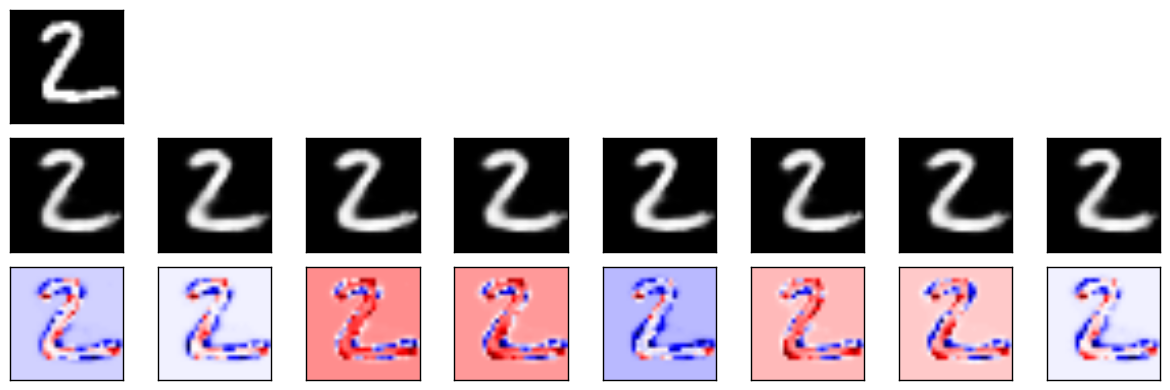

In [14]:
if make_20_small_only:
    show_multiple_draws(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            show_multiple_draws(latents, size)

In [15]:
def draw_predictions_set(num_latents, size):
    np.random.seed(random_seed)
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = VAE.predict(X_test, batch_size=batch_size)
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-predictions-'+str(num_latents)+'-'+str(size))
    plt.show()

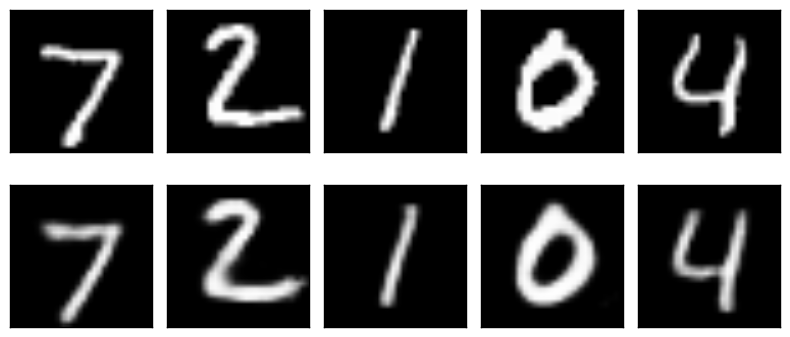

In [16]:
if make_20_small_only:
    draw_predictions_set(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_predictions_set(latents, size)

In [17]:
# add some noise to MNIST text latent variables and show results
def draw_noisy_predictions(num_latents, size, noise_scale):
    np.random.seed(random_seed)
    plt.clf()
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)

    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        latents = np.reshape(predictions[i], (1,latent_dim))
        for j in range(latent_dim):
            latents[0,j] += np.random.uniform(-noise_scale, noise_scale)
        decoder_prediction = generator.predict(latents)
        plt.subplot(2, 5, i+6)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-noisy-'+str(noise_scale)+'-'+str(num_latents)+'-'+str(size))
    plt.show()

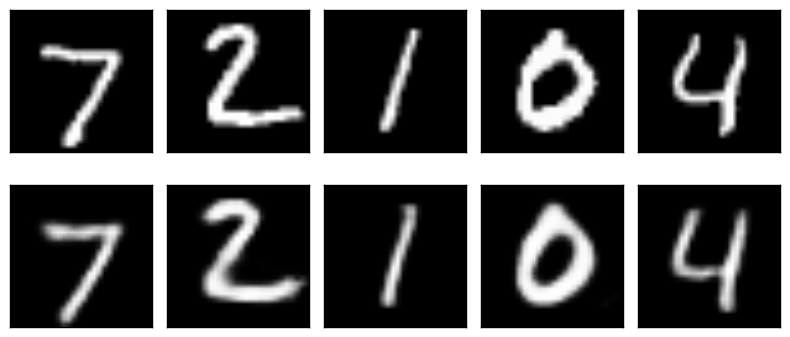

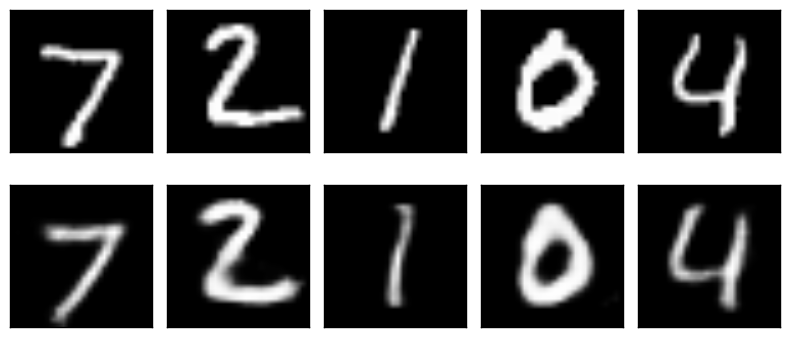

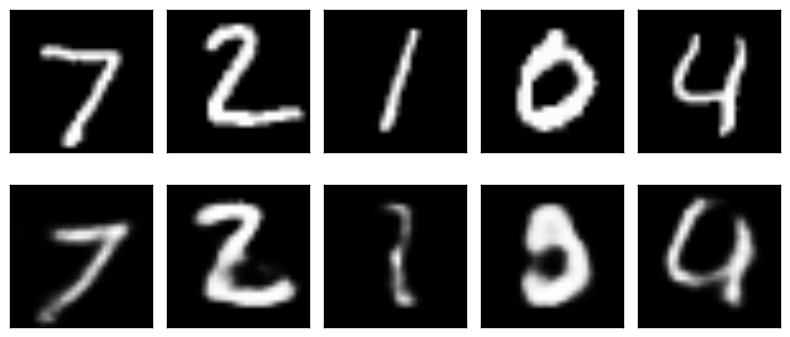

In [18]:
if make_20_small_only:
    for noise_scale in [.1, .5, 1.0]:
        draw_noisy_predictions(20, 'small', noise_scale)
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            for noise_scale in [.1, .5, 1.0]:
                draw_noisy_predictions(latents, size, noise_scale)

In [21]:
def draw_tiger(num_latents, size):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    
    filepath = file_helper.get_input_file_path("tiger-gray-28-28.png")
    im = Image.open(filepath) #Can be many different formats.
    pix = im.load()
    # rather than fiddle with the batch size, make this a stack of batch_size
    # images, only put the tiger in the first one
    tiger = np.zeros((batch_size,784))
    for y in range(28):
        for x in range(28):
            tiger[0,(y*28)+x] = pix[x,y][0]/255.

    plt.clf()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(tiger[0], (28, 28)), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplot(1, 2, 2)
    
    predictions = VAE.predict(tiger, batch_size=batch_size)
    predicted_tiger = predictions[0]

    plt.imshow(np.reshape(predicted_tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-tiger-'+str(num_latents)+'-'+str(size))
    plt.show()

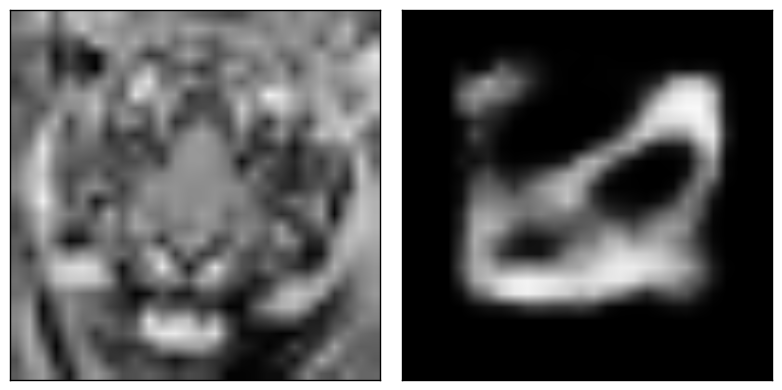

In [22]:
if make_20_small_only:
    draw_tiger(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_tiger(latents, size)

In [23]:
def draw_blend_grid(num_latents, size):
    # blend latents for pairs of images and decompress
    
    plt.clf()
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)
    np.random.seed(random_seed)

    plt.figure(figsize=(8, 5))
    offset = 18
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.subplot(3, 5, i+6)
        plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.subplot(3, 5, i+11)
        
        pre0 = predictions[i]
        pre1 = predictions[i+offset]
        latent_list = np.zeros((1, len(pre0)))
        for j in range(len(pre0)):
            latent_list[0,j] = (pre0[j] + pre1[j])/2.0

        decoder_prediction = generator.predict(latent_list)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-blend-grid-'+str(num_latents)+'-'+str(size))
    plt.show()

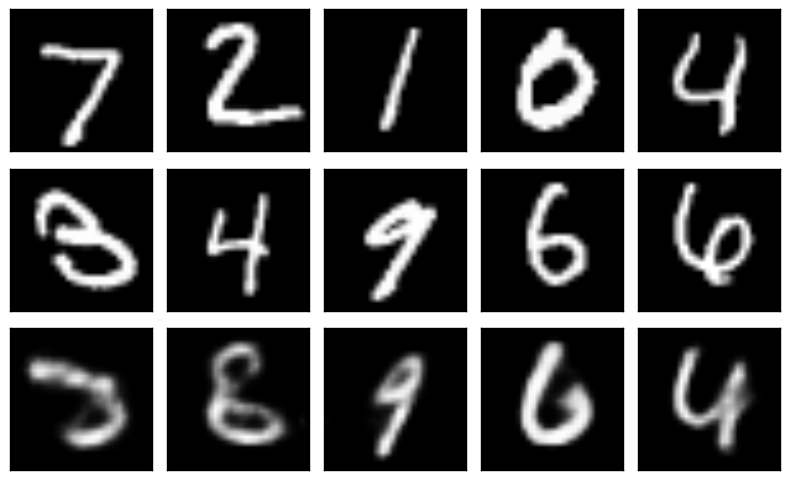

In [24]:
if make_20_small_only:
    draw_blend_grid(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draww_blend_grid(latents, size)

In [25]:
def draw_linear_blend(num_latents, size, steps):
    # blend latents for two test images and decompress
    np.random.seed(random_seed)

    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)
    
    start_list = [ predictions[4], predictions[23], predictions[29]]
    end_list = [ predictions[18], predictions[15], predictions[25]]
    plt.clf()
    plt.figure(figsize=(12, 5))
    num_rows = len(start_list)
    for row in range(num_rows):
        for i in range(steps):
            plt.subplot(num_rows, steps, (row*steps)+(i+1))
            alpha = i/(steps-1.0)
            latent_list = np.zeros((1, latent_dim))
            for j in range(latent_dim):
                latent_list[0,j] = start_list[row][j] + (alpha * (end_list[row][j] - start_list[row][j]))
                decoder_prediction = generator.predict(latent_list)
                plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
                ax = plt.gca()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-linear-set-'+str(num_latents)+'-'+str(size))
    plt.show()

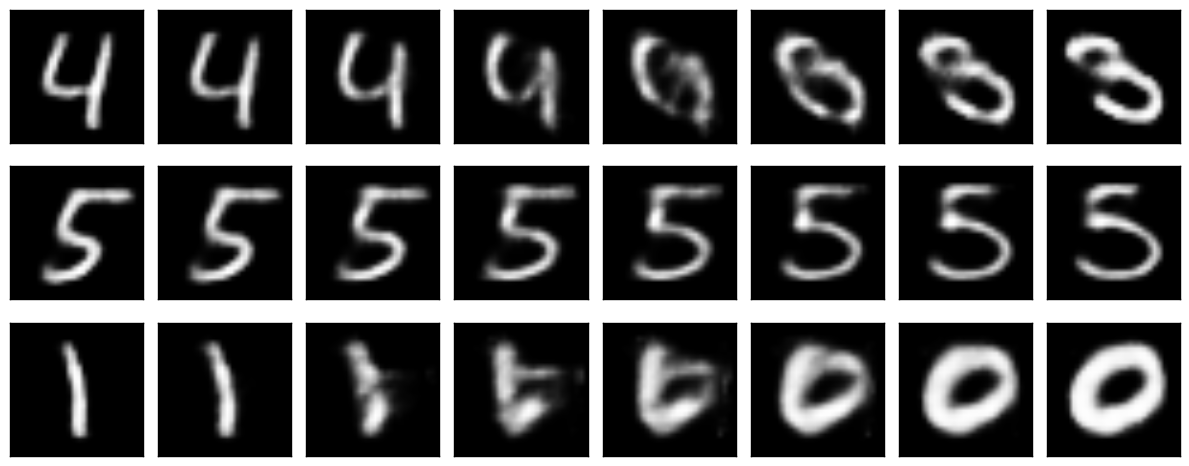

In [26]:
if make_20_small_only:
    draw_linear_blend(20, 'small', 8)
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_linear_blend(latents, size, 8)

In [27]:
def draw_VAE_scatter(size, marker_scale=1):
    np.random.seed(random_seed)
    # we only draw these for 2D versions
    (latent_dim, VAE, encoder, generator) = get_VAE_models(2, size)

    clrs = [ 'red', 'sandybrown', 'sienna', 'gold', 'palegreen',
            'limegreen', 'deepskyblue', 'blue', 'plum', 'magenta' ]
    
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')

    c = patches.Ellipse((0,0), 6, 6, edgecolor='black', fill=False)
    ax.add_patch(c)
    
    latent_list = encoder.predict(X_test, batch_size=batch_size)
    for i in range(len(latent_list)):
        mx = latent_list[i,0]
        my = latent_list[i,1]
        vx = marker_scale
        vy = marker_scale
        p = patches.Ellipse((mx,my), marker_scale, marker_scale,
                            edgecolor='black', facecolor=clrs[y_test[i]])
        ax.add_patch(p)
        
    handle_list = []
    for i in range(10):
        p = patches.Patch(color=clrs[i], label=str(i))
        handle_list.append(p)
    ax.legend(handles=handle_list, loc='lower right', shadow=True)
    
    ax.set_ylim([np.min(latent_list[:,1]), np.max(latent_list[:,1])])
    ax.set_xlim([np.min(latent_list[:,0]), np.max(latent_list[:,0])])

    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    file_helper.save_figure('NB4-VAE-scatter-circles-2-'+str(size))


    plt.show()

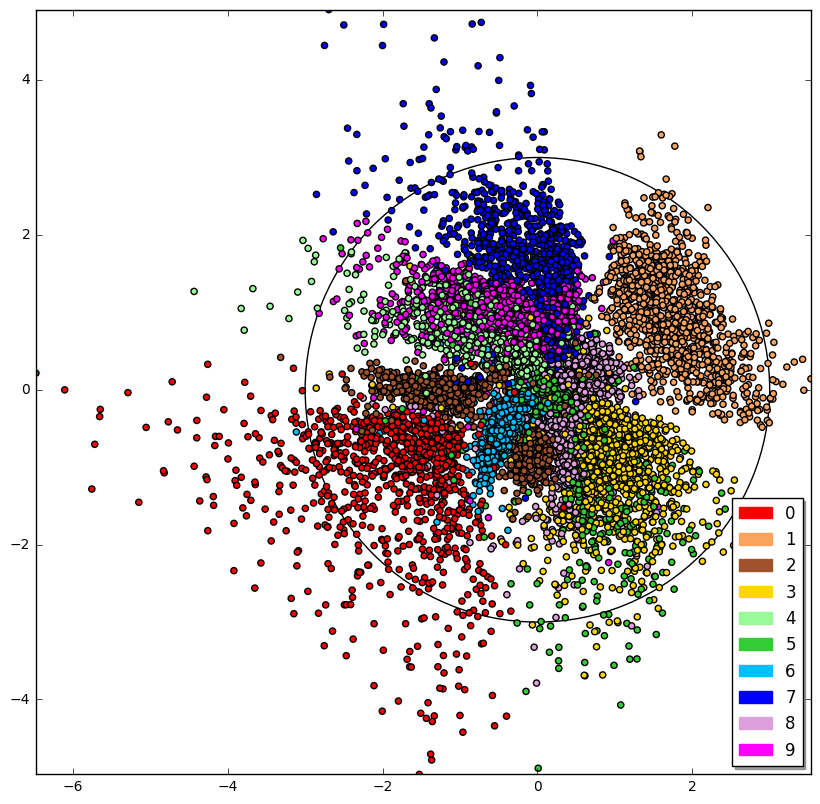

In [28]:
draw_VAE_scatter('small', marker_scale=.08)

In [29]:
def draw_VAE_decoder_grid(size, steps=17):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(2, size)

    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * steps, digit_size * steps))
    # generate inputs to match up with the scatter plot 
    grid_x = np.linspace(2, -2, steps)
    grid_y = np.linspace(-2, 2, steps)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(figure, cmap='gray')
    file_helper.save_figure('NB4-VAE-decoder-grid-2-'+str(size))
    plt.show()

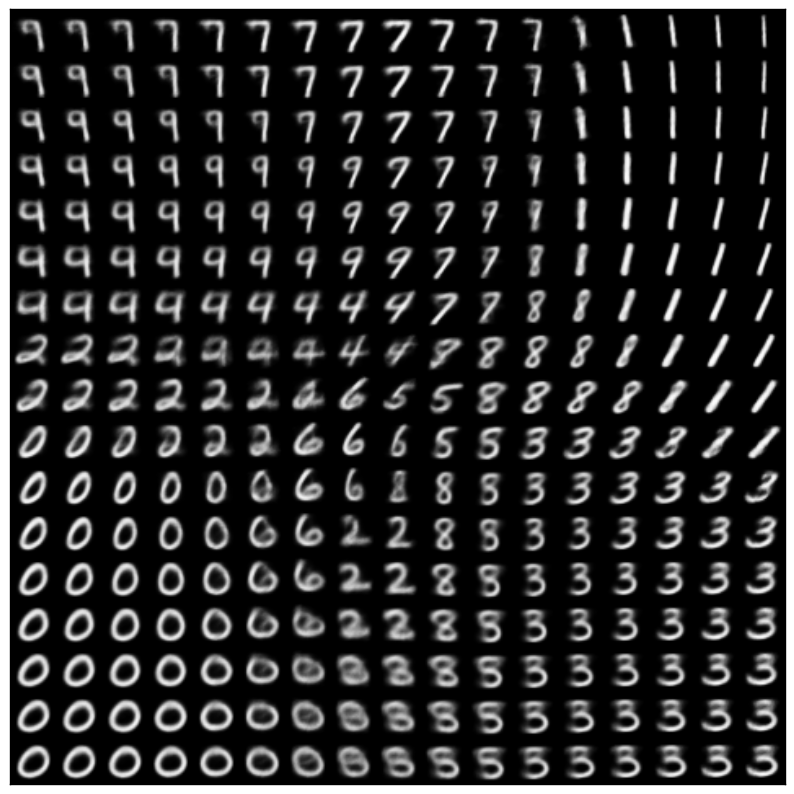

In [30]:
draw_VAE_decoder_grid('small', 17)

In [31]:
# drive the VAE with random latent variables and see what comes out
def draw_random_VAE(num_latents, size, noise_range):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    
    np.random.seed(random_seed)
    plt.figure(figsize=(10, 8))
    rows = 8
    cols = 10
    for y in range(rows):
        for x in range(cols):
            plt.subplot(rows, cols, 1+x+(y*cols))
            latents = np.random.uniform(-noise_range, noise_range, (1, latent_dim))
            decoder_prediction = generator.predict(latents)
            plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure('NB4-VAE-random-'+str(noise_range)+'-'+str(num_latents)+'-'+str(size))
    plt.show()

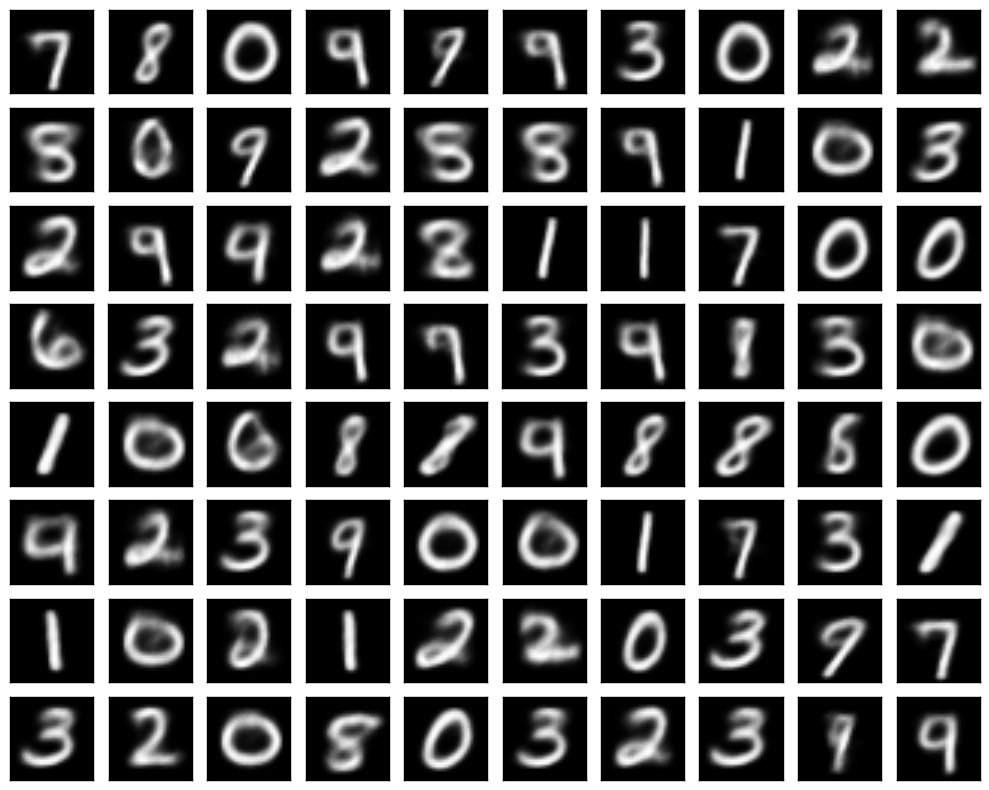

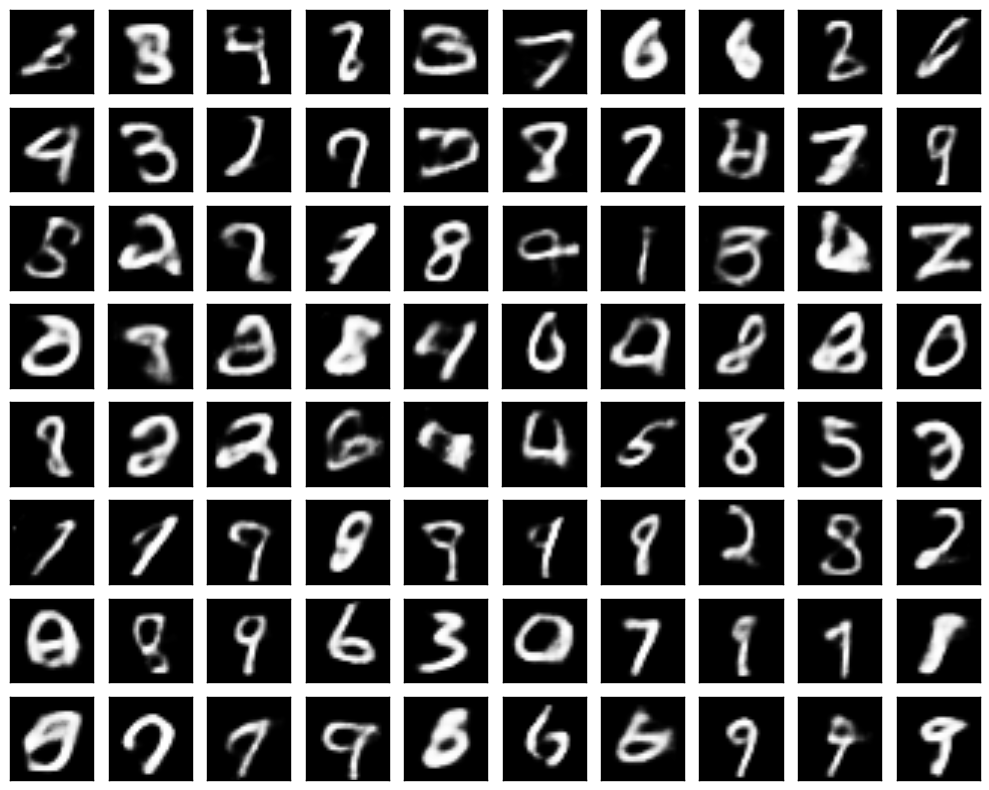

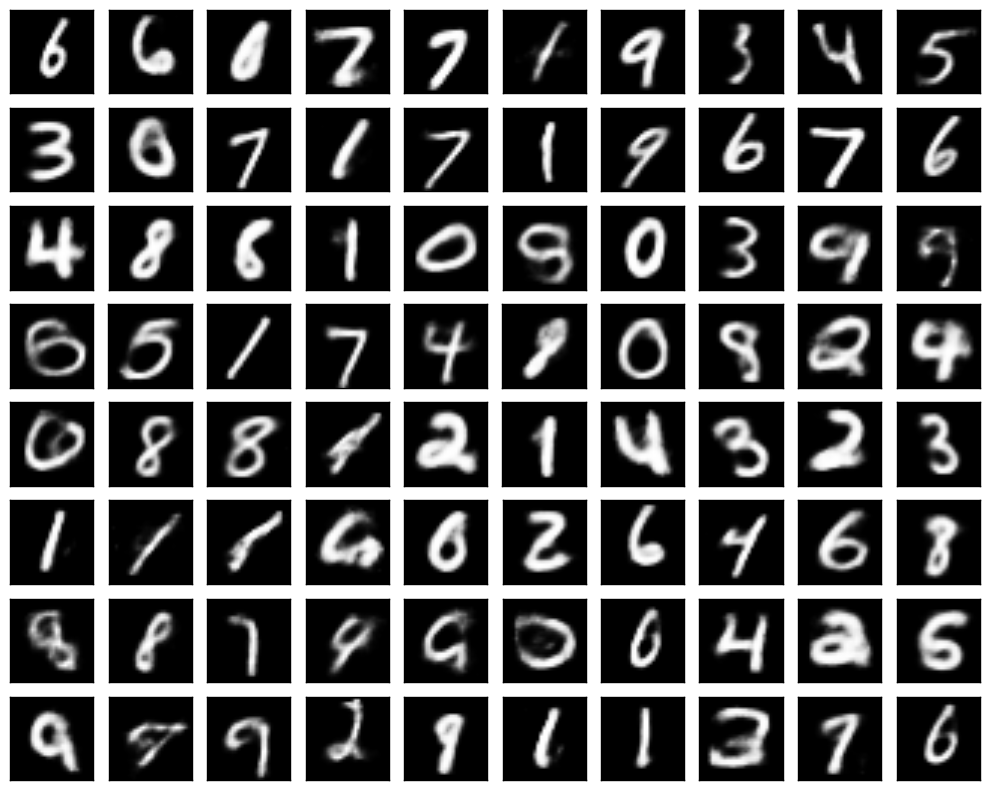

In [32]:
if make_20_small_only:
    draw_random_VAE(2, 'small', 2)
    draw_random_VAE(20, 'small', 2)
    draw_random_VAE(50, 'big', 2)  # not really 20_small but we want both
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_random_VAE(latents, size, 3)